# LSTM Modelling 

In [1]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import GroupKFold

import warnings
warnings.filterwarnings("ignore")

2023-06-07 16:01:44.550993: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-07 16:01:44.587141: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-07 16:01:44.587867: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 16:01:45.369261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Refactor

In [2]:
dataset = pd.read_csv("../StationsDatasets/dataset.csv").drop(columns=["Unnamed: 0"])

In [3]:
trips = pd.read_csv("../CSVFiles/datatrips.csv").drop(columns=["Unnamed: 0"])

day = []
year = []
for trip in trips.values:
    date = datetime.strptime(trip[0], "%Y-%m-%d %H:%M:%S").timetuple()
    day.append(date.tm_yday)
    year.append(date.tm_year)

trips = trips.drop(columns=["DateEnd"])
trips["Day"] = day
trips["Year"] = year

In [7]:
new_data = pd.DataFrame({"Holiday": [], "Weekday": [], "WeatherSituation": [], "Temp": [], "ATemp": [], "Humidity": [], "Windspeed": []})

for data in dataset.values:
    hour = data[0]
    station = data[1]
    day = data[3]
    year = data[4]

    df = trips.loc[(trips["StationEnd"] == station) & (trips["Day"] == day) & (trips["Year"] == year) & (trips["Hour"] == hour)].values[0][6:-1]
    new_data.loc[len(new_data)] = np.delete(df, 2)

dataset = dataset.join(new_data)

In [8]:
dataset.to_csv("../StationsDatasets/dataset.csv")

## Correlation Features

In [9]:
def featureSelect_dataframe(X, y, criteria, k):

    # initialize our function/method
    reg = SelectKBest(criteria, k=k).fit(X,y)
    
    # transform after creating the reg (so we can use getsupport)
    X_transformed = reg.transform(X)

    # filter down X based on kept columns
    X = X[[val for i,val in enumerate(X.columns) if reg.get_support()[i]]]

    # return that dataframe
    return X, reg.scores_

X = dataset[[col for col in dataset.columns if "Count" not in col]]
y = dataset['Count']

new_x_data = []

# F-value between label/feature for regression tasks.
New_X, scoresX = featureSelect_dataframe(X, y, f_regression, 11)
new_x_data_1 = {list(X.columns)[x]:scoresX[x] for x in range(0,len(list(X.columns)))}
pprint(sorted(new_x_data_1.items(), key=lambda x:x[1], reverse=True))

[('Temp', 7854.233184039789),
 ('ATemp', 7706.912809130377),
 ('Year', 5350.628642028699),
 ('Humidity', 5196.287790444266),
 ('Hour', 2591.040359724638),
 ('WeatherSituation', 1576.8091838740354),
 ('Windspeed', 261.06541187993037),
 ('Day', 225.13003715150458),
 ('StationEnd', 215.19085620330532),
 ('Holiday', 60.46833284115195),
 ('Weekday', 48.945415173314345),
 ('WorkingDay', 35.49851955888466)]


## LSTM

In [19]:
epochs = 1
batch_size = 1
verbose = 2

MSE = [3.7657360315322874, 3.7108171939849854, 3.7040705919265746, 3.7200965166091917, 3.7754531145095824, 3.7854664802551268, 3.7315561532974244, 3.831954526901245]

### Method 0
Input: c(t), StationEnd

Output: c(t+1)

In [5]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-06-07 16:02:00.556529: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-07 16:02:00.557122: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-07 16:02:00.941681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gra

182739/182739 - 215s - loss: 3.9945 - accuracy: 0.3225 - 215s/epoch - 1ms/step


2023-06-07 16:05:36.920356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 16:05:36.923443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 16:05:36.925068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 248s - loss: 3.7961 - accuracy: 0.3328 - 248s/epoch - 1ms/step
183211/183211 - 231s - loss: 3.7700 - accuracy: 0.3340 - 231s/epoch - 1ms/step
182778/182778 - 201s - loss: 3.7516 - accuracy: 0.3362 - 201s/epoch - 1ms/step
182903/182903 - 199s - loss: 3.7651 - accuracy: 0.3344 - 199s/epoch - 1ms/step
183284/183284 - 224s - loss: 3.8075 - accuracy: 0.3317 - 224s/epoch - 1ms/step
182908/182908 - 178s - loss: 3.7783 - accuracy: 0.3324 - 178s/epoch - 974us/step
182892/182892 - 164s - loss: 3.7471 - accuracy: 0.3334 - 164s/epoch - 898us/step
182676/182676 - 164s - loss: 3.7478 - accuracy: 0.3330 - 164s/epoch - 898us/step
182421/182421 - 164s - loss: 3.7339 - accuracy: 0.3351 - 164s/epoch - 900us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.530080318450928 - Accuracy: 42.98296570777893%
------------------------------------------------------

Text(0.5, 0, 'Methods')

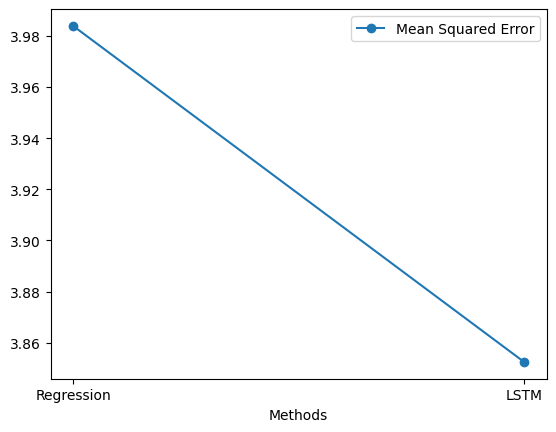

In [9]:
plt.plot(["Regression", "LSTM"], [3.9839102446556587, 3.8524561882019044], marker="o")
plt.legend(["Mean Squared Error"])
plt.xlabel("Methods")

### Method 1
Input: ..., Temp

Output: c(t+1)

In [6]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-06-07 16:35:16.743988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 16:35:16.745829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 16:35:16.746962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 164s - loss: 3.9385 - accuracy: 0.3225 - 164s/epoch - 897us/step


2023-06-07 16:38:00.941405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 16:38:00.942856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 16:38:00.944107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 164s - loss: 3.6970 - accuracy: 0.3328 - 164s/epoch - 886us/step
183211/183211 - 162s - loss: 3.6466 - accuracy: 0.3338 - 162s/epoch - 882us/step
182778/182778 - 161s - loss: 3.6279 - accuracy: 0.3359 - 161s/epoch - 880us/step
182903/182903 - 161s - loss: 3.6323 - accuracy: 0.3343 - 161s/epoch - 880us/step
183284/183284 - 162s - loss: 3.7046 - accuracy: 0.3321 - 162s/epoch - 884us/step
182908/182908 - 162s - loss: 3.6911 - accuracy: 0.3329 - 162s/epoch - 884us/step
182892/182892 - 162s - loss: 3.6892 - accuracy: 0.3338 - 162s/epoch - 886us/step
182676/182676 - 167s - loss: 3.6996 - accuracy: 0.3333 - 167s/epoch - 916us/step
182421/182421 - 170s - loss: 3.6760 - accuracy: 0.3347 - 170s/epoch - 931us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.918455123901367 - Accuracy: 42.818427085876465%
-------------------------------------------

### Method 2
Input: ..., Temp, ATemp

Output: c(t+1)

In [7]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-06-07 17:02:36.815691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 17:02:36.816948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 17:02:36.818000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 165s - loss: 3.9001 - accuracy: 0.3226 - 165s/epoch - 905us/step


2023-06-07 17:05:22.522680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 17:05:22.524266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 17:05:22.525496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 164s - loss: 3.7051 - accuracy: 0.3327 - 164s/epoch - 885us/step
183211/183211 - 162s - loss: 3.6441 - accuracy: 0.3338 - 162s/epoch - 885us/step
182778/182778 - 161s - loss: 3.6411 - accuracy: 0.3360 - 161s/epoch - 883us/step
182903/182903 - 162s - loss: 3.6450 - accuracy: 0.3346 - 162s/epoch - 884us/step
183284/183284 - 162s - loss: 3.7004 - accuracy: 0.3322 - 162s/epoch - 882us/step
182908/182908 - 161s - loss: 3.7041 - accuracy: 0.3334 - 161s/epoch - 878us/step
182892/182892 - 161s - loss: 3.7098 - accuracy: 0.3345 - 161s/epoch - 880us/step
182676/182676 - 161s - loss: 3.7172 - accuracy: 0.3338 - 161s/epoch - 882us/step
182421/182421 - 161s - loss: 3.6951 - accuracy: 0.3357 - 161s/epoch - 884us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.546429634094238 - Accuracy: 42.9539293050766%
---------------------------------------------

### Method 3
Input: ..., Temp, ATemp, Humidity

Output: c(t+1)

In [8]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-06-07 17:29:42.036588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 17:29:42.038490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 17:29:42.039626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 166s - loss: 3.8790 - accuracy: 0.3225 - 166s/epoch - 911us/step


2023-06-07 17:32:28.769661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 17:32:28.771182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 17:32:28.772033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 166s - loss: 3.6911 - accuracy: 0.3329 - 166s/epoch - 896us/step
183211/183211 - 164s - loss: 3.6659 - accuracy: 0.3342 - 164s/epoch - 893us/step
182778/182778 - 162s - loss: 3.6454 - accuracy: 0.3367 - 162s/epoch - 888us/step
182903/182903 - 163s - loss: 3.6409 - accuracy: 0.3351 - 163s/epoch - 889us/step
183284/183284 - 163s - loss: 3.6790 - accuracy: 0.3323 - 163s/epoch - 888us/step
182908/182908 - 162s - loss: 3.6742 - accuracy: 0.3327 - 162s/epoch - 886us/step
182892/182892 - 162s - loss: 3.6696 - accuracy: 0.3332 - 162s/epoch - 887us/step
182676/182676 - 162s - loss: 3.6779 - accuracy: 0.3326 - 162s/epoch - 889us/step
182421/182421 - 162s - loss: 3.6575 - accuracy: 0.3344 - 162s/epoch - 888us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.609354019165039 - Accuracy: 42.98296570777893%
--------------------------------------------

### Method 4
Input: ..., Temp, ATemp, Humidity, WeatherSituation

Output: c(t+1)

In [10]:
dataset = pd.get_dummies(data=dataset, columns=["WeatherSituation"], dtype=int)

In [11]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "WeatherSituation_1.0", "WeatherSituation_2.0", "WeatherSituation_3.0", "WeatherSituation_4.0", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-06-09 09:11:17.128295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 09:11:17.129387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-09 09:11:17.130208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 187s - loss: 3.8926 - accuracy: 0.3224 - 187s/epoch - 1ms/step


2023-06-09 09:14:24.394433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 09:14:24.395773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-09 09:14:24.397125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 183s - loss: 3.6548 - accuracy: 0.3327 - 183s/epoch - 989us/step
183211/183211 - 171s - loss: 3.5998 - accuracy: 0.3334 - 171s/epoch - 933us/step
182778/182778 - 166s - loss: 3.5343 - accuracy: 0.3360 - 166s/epoch - 906us/step
182903/182903 - 166s - loss: 3.5333 - accuracy: 0.3344 - 166s/epoch - 905us/step
183284/183284 - 165s - loss: 3.5843 - accuracy: 0.3324 - 165s/epoch - 901us/step
182908/182908 - 165s - loss: 3.5734 - accuracy: 0.3335 - 165s/epoch - 905us/step
182892/182892 - 165s - loss: 3.5664 - accuracy: 0.3343 - 165s/epoch - 905us/step
182676/182676 - 165s - loss: 3.5670 - accuracy: 0.3341 - 165s/epoch - 901us/step
182421/182421 - 177s - loss: 3.5431 - accuracy: 0.3356 - 177s/epoch - 972us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 5.115689754486084 - Accuracy: 42.9539293050766%
---------------------------------------------

### Method 5
Input: ..., Temp, ATemp, Humidity, WeatherSituation, Windspeed

Output: c(t+1)

In [12]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "WeatherSituation_1.0", "WeatherSituation_2.0", "WeatherSituation_3.0", "WeatherSituation_4.0", "Humidity", "Windspeed"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-06-09 09:39:53.098624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 09:39:53.100128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-09 09:39:53.101226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 177s - loss: 3.9005 - accuracy: 0.3226 - 177s/epoch - 969us/step


2023-06-09 09:42:50.907021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 09:42:50.908389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-09 09:42:50.909456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 190s - loss: 3.6948 - accuracy: 0.3326 - 190s/epoch - 1ms/step
183211/183211 - 173s - loss: 3.6948 - accuracy: 0.3342 - 173s/epoch - 943us/step
182778/182778 - 170s - loss: 3.6786 - accuracy: 0.3366 - 170s/epoch - 930us/step
182903/182903 - 167s - loss: 3.7042 - accuracy: 0.3353 - 167s/epoch - 912us/step
183284/183284 - 166s - loss: 3.7582 - accuracy: 0.3329 - 166s/epoch - 908us/step
182908/182908 - 166s - loss: 3.7608 - accuracy: 0.3339 - 166s/epoch - 910us/step
182892/182892 - 166s - loss: 3.7647 - accuracy: 0.3345 - 166s/epoch - 909us/step
182676/182676 - 166s - loss: 3.7600 - accuracy: 0.3343 - 166s/epoch - 908us/step
182421/182421 - 165s - loss: 3.7476 - accuracy: 0.3357 - 165s/epoch - 905us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.370424747467041 - Accuracy: 42.99748241901398%
----------------------------------------------

### Method 6
Input: ..., Temp, ATemp, WeatherSituation, Windspeed

Output: c(t+1)

In [13]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "WeatherSituation_1.0", "WeatherSituation_2.0", "WeatherSituation_3.0", "WeatherSituation_4.0", "Windspeed"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-06-09 10:08:26.892331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 10:08:26.893675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-09 10:08:26.894511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 166s - loss: 3.8778 - accuracy: 0.3229 - 166s/epoch - 910us/step


2023-06-09 10:11:13.389273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 10:11:13.390199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-09 10:11:13.391068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 165s - loss: 3.7094 - accuracy: 0.3328 - 165s/epoch - 895us/step
183211/183211 - 164s - loss: 3.7009 - accuracy: 0.3337 - 164s/epoch - 896us/step
182778/182778 - 163s - loss: 3.6864 - accuracy: 0.3356 - 163s/epoch - 894us/step
182903/182903 - 179s - loss: 3.6994 - accuracy: 0.3338 - 179s/epoch - 980us/step
183284/183284 - 180s - loss: 3.7665 - accuracy: 0.3318 - 180s/epoch - 984us/step
182908/182908 - 180s - loss: 3.7659 - accuracy: 0.3327 - 180s/epoch - 985us/step
182892/182892 - 178s - loss: 3.7467 - accuracy: 0.3334 - 178s/epoch - 972us/step
182676/182676 - 175s - loss: 3.7135 - accuracy: 0.3328 - 175s/epoch - 957us/step
182421/182421 - 171s - loss: 3.6788 - accuracy: 0.3343 - 171s/epoch - 939us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.778624057769775 - Accuracy: 42.99748241901398%
--------------------------------------------

### Method 7
Input: ..., Temp, Humidity, WeatherSituation, Windspeed

Output: c(t+1)

In [14]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "Humidity", "WeatherSituation_1.0", "WeatherSituation_2.0", "WeatherSituation_3.0", "WeatherSituation_4.0", "Windspeed"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-06-09 10:37:15.717048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 10:37:15.719061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-09 10:37:15.720034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 169s - loss: 3.9035 - accuracy: 0.3224 - 169s/epoch - 926us/step


2023-06-09 10:40:05.241130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 10:40:05.242560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-09 10:40:05.243586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 158s - loss: 3.7028 - accuracy: 0.3331 - 158s/epoch - 853us/step
183211/183211 - 162s - loss: 3.6920 - accuracy: 0.3347 - 162s/epoch - 882us/step
182778/182778 - 169s - loss: 3.6576 - accuracy: 0.3373 - 169s/epoch - 924us/step
182903/182903 - 165s - loss: 3.6309 - accuracy: 0.3356 - 165s/epoch - 901us/step
183284/183284 - 162s - loss: 3.6645 - accuracy: 0.3332 - 162s/epoch - 886us/step
182908/182908 - 158s - loss: 3.6510 - accuracy: 0.3343 - 158s/epoch - 865us/step
182892/182892 - 158s - loss: 3.6337 - accuracy: 0.3349 - 158s/epoch - 862us/step
182676/182676 - 160s - loss: 3.6486 - accuracy: 0.3346 - 160s/epoch - 876us/step
182421/182421 - 162s - loss: 3.6199 - accuracy: 0.3360 - 162s/epoch - 889us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.5540266036987305 - Accuracy: 42.99748241901398%
-------------------------------------------

### Method 8
Input: ..., Temp, Humidity, Windspeed

Output: c(t+1)

In [18]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "Humidity", "Windspeed"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-06-09 11:06:57.973510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 11:06:57.974606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-09 11:06:57.975325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 171s - loss: 3.9100 - accuracy: 0.3224 - 171s/epoch - 934us/step


2023-06-09 11:09:48.999252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 11:09:49.000396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-09 11:09:49.001127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 174s - loss: 3.7107 - accuracy: 0.3331 - 174s/epoch - 939us/step
183211/183211 - 167s - loss: 3.7044 - accuracy: 0.3345 - 167s/epoch - 913us/step
182778/182778 - 163s - loss: 3.6919 - accuracy: 0.3369 - 163s/epoch - 893us/step
182903/182903 - 175s - loss: 3.6982 - accuracy: 0.3355 - 175s/epoch - 959us/step
183284/183284 - 166s - loss: 3.7668 - accuracy: 0.3333 - 166s/epoch - 907us/step
182908/182908 - 166s - loss: 3.7588 - accuracy: 0.3343 - 166s/epoch - 907us/step
182892/182892 - 171s - loss: 3.7501 - accuracy: 0.3352 - 171s/epoch - 933us/step
182676/182676 - 175s - loss: 3.7491 - accuracy: 0.3346 - 175s/epoch - 957us/step
182421/182421 - 176s - loss: 3.7203 - accuracy: 0.3362 - 176s/epoch - 964us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.526387691497803 - Accuracy: 42.99748241901398%
--------------------------------------------

## Graphs

Text(0.5, 0, 'Methods')

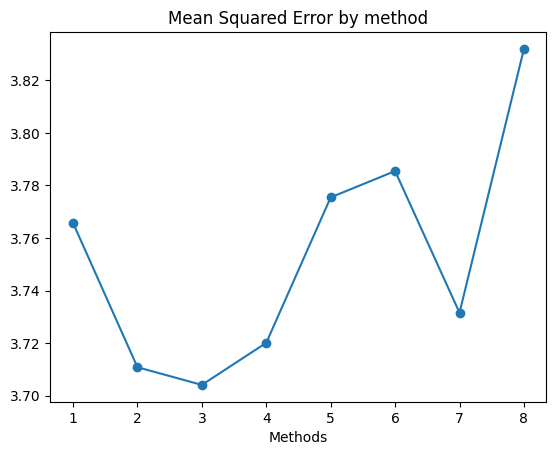

In [20]:
plt.plot(list(range(1,len(MSE)+1)), MSE, marker="o")
plt.title("Mean Squared Error by method")
plt.xlabel("Methods")

Text(0.5, 0, 'Methods')

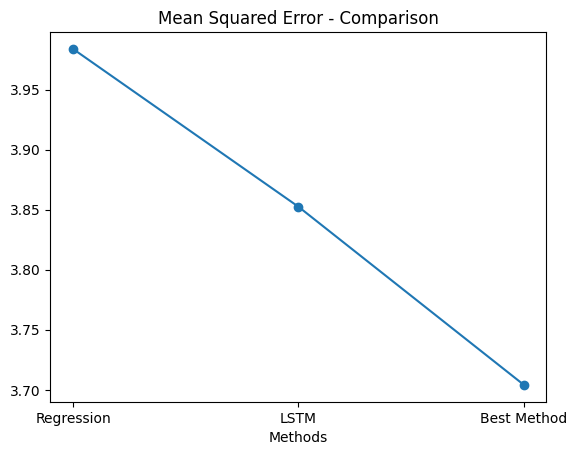

In [17]:
plt.plot(["Regression", "LSTM", "Best Method"], [3.9839102446556587, 3.8524561882019044, 3.7040705919265746], marker="o")
plt.title("Mean Squared Error - Comparison")
plt.xlabel("Methods")